In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# Changing the Linear Components

Here we calculate trends using the SAGE II/OSIRIS/OMPS-LP Dataset.  Trends are calculated in the following ways

* With two linear terms that have a join point at 1997.
* Same as above but with the join point changed to 2000
* By fitting ozone anomalies without any linear component, and then fitting the residuals to a linear term
* Using two orthogonal forms of the EESC

Start with some imports and loading in the data

In [2]:
import xarray as xr
import numpy as np
from LOTUS_regression.regression import regress_all_bins
from LOTUS_regression.predictors import load_data
import LOTUS_regression.predictors.download as download
import LOTUS_regression.plotting.trends as trends
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import time

In [3]:
MERGED_FILE = r'/home/runner/work/lotus-regression/lotus-regression/test_data//S2_OS_OMPS/MERGED_LOTUS.nc'

mzm_data = xr.open_dataset(MERGED_FILE, engine='netcdf4')

We have our default set of predictors which contains linear terms joining at 1997

In [4]:
predictors = load_data('pred_baseline_pwlt.csv').to_period('M')

print(predictors.columns)

Index(['enso', 'solar', 'qboA', 'qboB', 'aod', 'linear_pre', 'linear_post',
       'constant'],
      dtype='object')


And our default set of trends

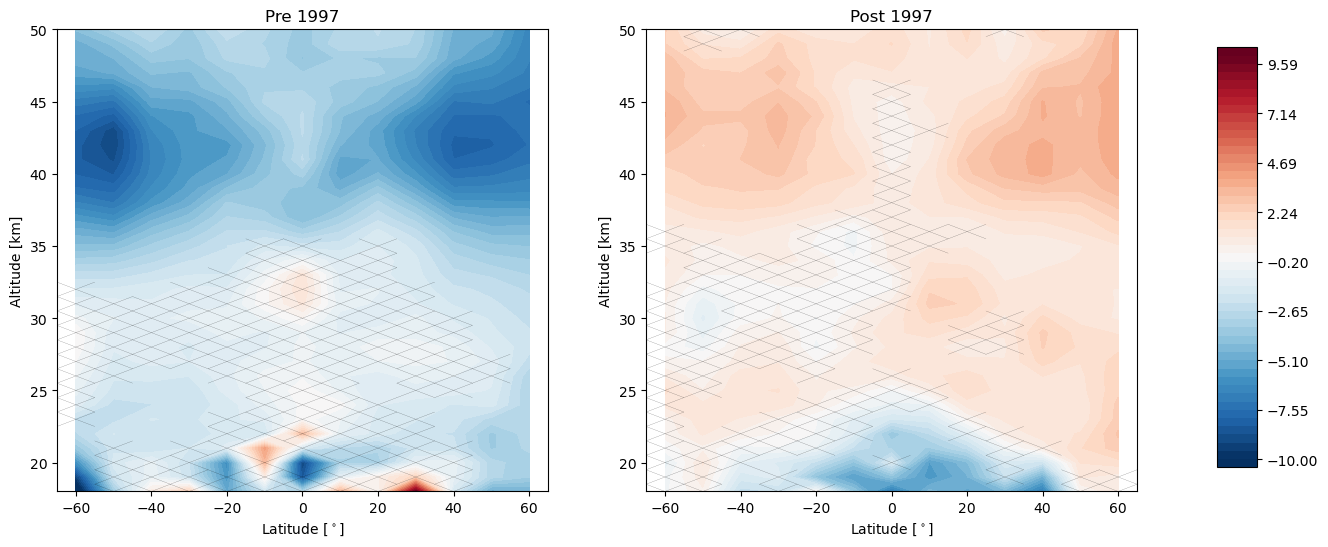

In [5]:
mzm_data = mzm_data.sel(mean_latitude=slice(-60, 60), altitude=slice(10, 50))  # remove bins without data
results = regress_all_bins(predictors, mzm_data['relative_anomaly'], tolerance=0.1)

# Convert to ~ percent
results *= 100

trends.pre_post_with_confidence(results, x='mean_latitude', y='altitude', ylim=(18, 50), log_y=False, figsize=(16, 6),
                                x_label='Latitude [$^\circ$]', y_label='Altitude [km]', pre_title='Pre 1997',
                                post_title='Post 1997')

Now we change our inflection point in the linear trend to 2000 instead of 1997, and repeat the analysis

<Axes: xlabel='time'>

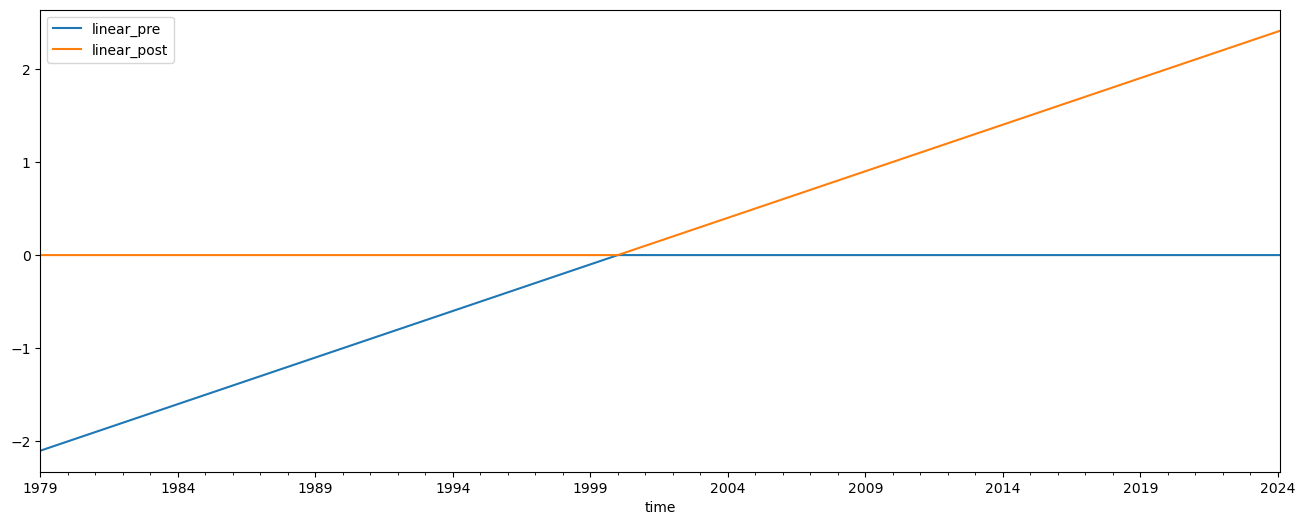

In [6]:
predictors[['linear_pre', 'linear_post']] = download.load_linear(inflection=2000)[['pre','post']]

predictors[['linear_pre', 'linear_post']].plot(figsize=(16, 6))

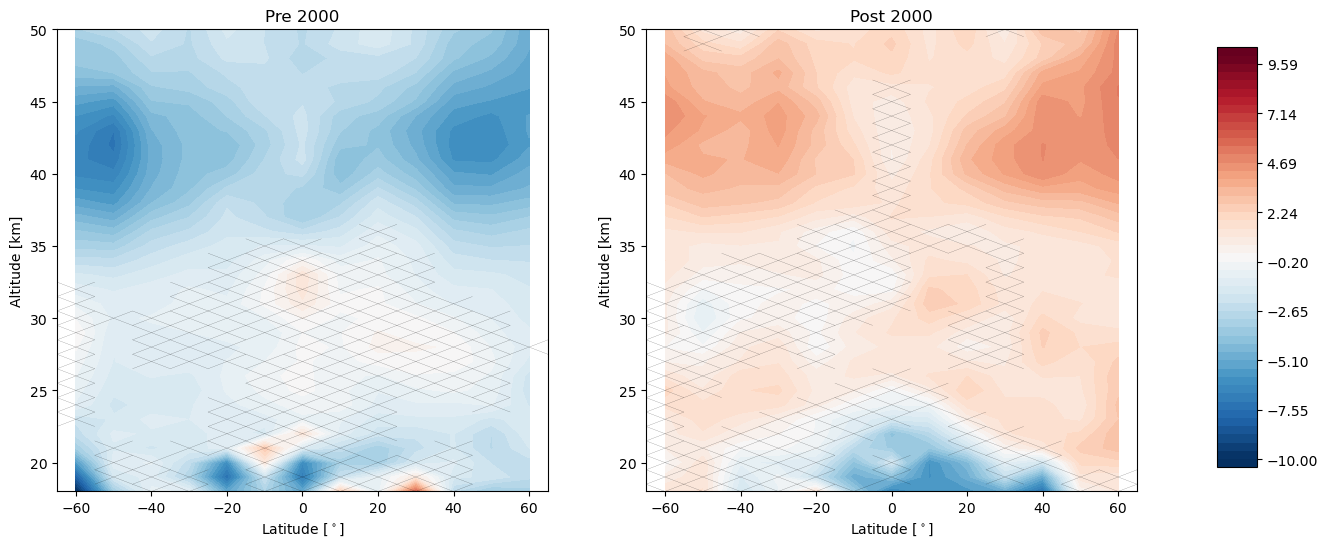

In [7]:
results = regress_all_bins(predictors, mzm_data['relative_anomaly'], tolerance=0.1)

# Convert to ~ percent
results *= 100

trends.pre_post_with_confidence(results, x='mean_latitude', y='altitude', ylim=(18, 50), log_y=False, figsize=(16, 6),
                                x_label='Latitude [$^\circ$]', y_label='Altitude [km]', pre_title='Pre 2000',
                                post_title='Post 2000')

Now we remove the linear terms from our predictors and tell the regression call to post fit a trend to the residuals after the year 2000

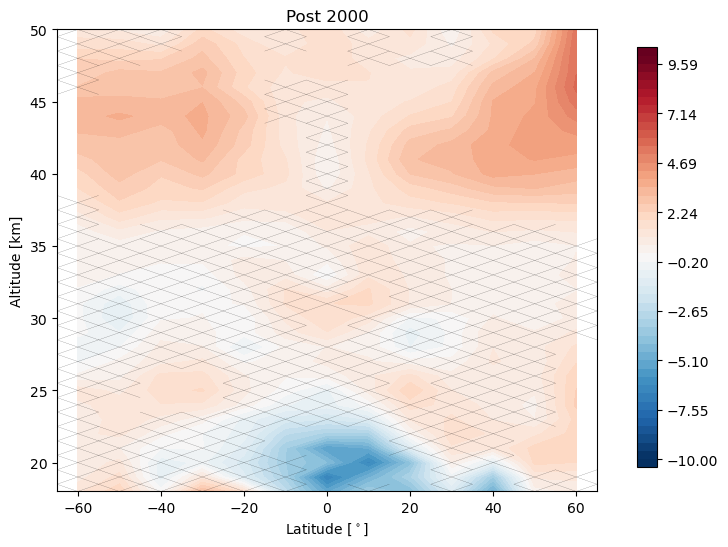

In [8]:
predictors = predictors.drop(['linear_pre', 'linear_post'], axis=1)

results = regress_all_bins(predictors, mzm_data['relative_anomaly'], tolerance=0.1, post_fit_trend_start='2000-01-01')

# Convert to ~ percent
results *= 100

trends.post_with_confidence(results, x='mean_latitude', y='altitude', ylim=(18, 50), log_y=False, figsize=(8, 6),
                                x_label='Latitude [$^\circ$]', y_label='Altitude [km]',
                                post_title='Post 2000')

Lastly we add two orthogonal EESC terms and redo the regression

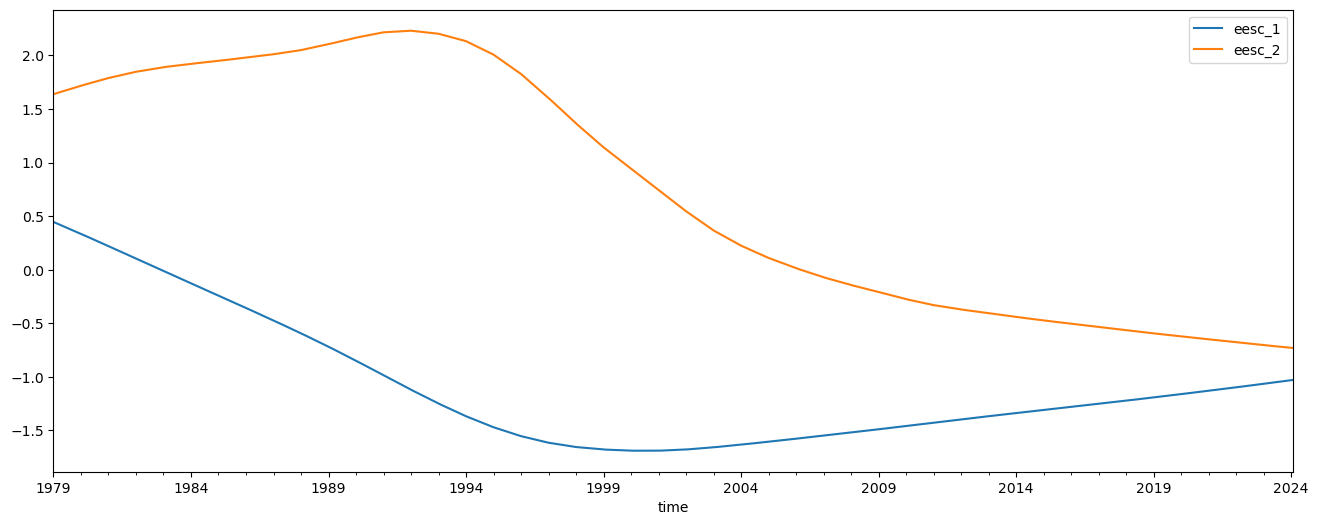

In [9]:
predictors[['eesc_1', 'eesc_2']] = download.load_orthogonal_eesc('/home/runner/work/lotus-regression/lotus-regression/test_data/EESC.txt')[['eesc_1', 'eesc_2']]

predictors[['eesc_1', 'eesc_2']].plot(figsize=(16, 6))

results = regress_all_bins(predictors, mzm_data['relative_anomaly'], tolerance=0.1)

The results are trickier to interpret, but we can combine the two EESC terms to find the total contribution in each bin for the EESC

Text(0.5, 1.0, 'EESC Contribution at 45 S, 40 km')

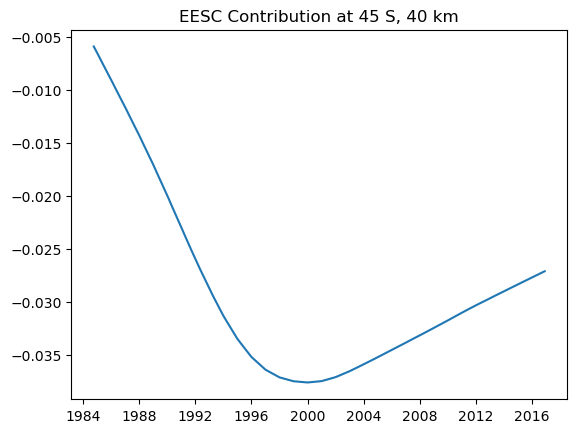

In [10]:
predictors = predictors[(pd.to_datetime(predictors.index.to_timestamp()) >= mzm_data.time.values[0]) & (pd.to_datetime(predictors.index.to_timestamp()) <= mzm_data.time.values[-1])]

eesc_contrib = results['eesc_1'].values[:, :, np.newaxis] * predictors['eesc_1'].values[np.newaxis, np.newaxis, :] +\
               results['eesc_2'].values[:, :, np.newaxis] * predictors['eesc_2'].values[np.newaxis, np.newaxis, :]
    
plt.plot(mzm_data.time.values, eesc_contrib[2, 40, :].T)
np.shape(eesc_contrib)
plt.title('EESC Contribution at 45 S, 40 km')

With some annoying time conversions we can also find the predicted turnaround time in each bin

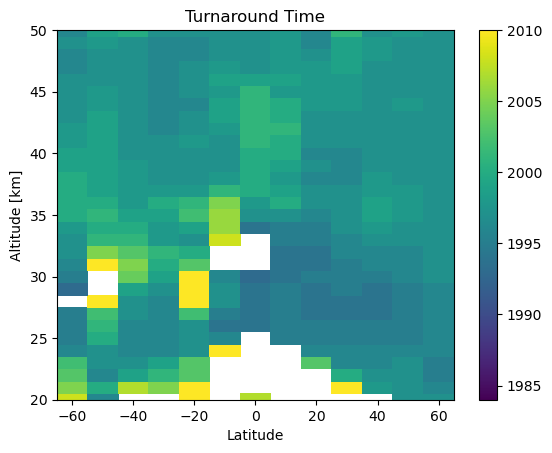

In [11]:
turnaround_index = np.argmin(eesc_contrib, axis=2)

turnaround_times = mzm_data.time.values[turnaround_index]

def to_year_fraction(date):
    def since_epoch(date): # returns seconds since epoch
        return time.mktime(date.timetuple())
    
    try:
        ts = (np.datetime64(date, 'ns') - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')
    except:
        print(np.datetime64(date))
        return np.nan

    dt = datetime.utcfromtimestamp(ts)
    s = since_epoch

    year = dt.year
    startOfThisYear = datetime(year=year, month=1, day=1)
    startOfNextYear = datetime(year=year+1, month=1, day=1)

    yearElapsed = s(dt) - s(startOfThisYear)
    yearDuration = s(startOfNextYear) - s(startOfThisYear)
    fraction = yearElapsed / yearDuration

    return dt.year + fraction

turnaround_times = np.frompyfunc(to_year_fraction, 1, 1)(turnaround_times).astype(float)

turnaround_times[turnaround_index == 0] = np.nan
turnaround_times[turnaround_index == len(mzm_data.time.values)-1] = np.nan

plt.pcolor(mzm_data.mean_latitude.values, mzm_data.altitude.values, np.ma.masked_invalid(turnaround_times.T))
plt.clim(1984, 2010)
plt.ylim(20, 50)
plt.ylabel('Altitude [km]')
plt.xlabel('Latitude')
plt.title('Turnaround Time')
plt.colorbar()